## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Захватаев Михаил Дмитриевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

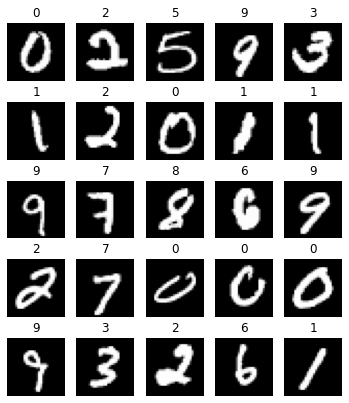

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [56]:
def init_layer(layer, mean=0.0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [96]:
def check(mean, std, activation=nn.Tanh()):
    
    layers = []
    sizes = [28*28] + [500]*10 + [10]

    for size_input, size_output in zip(sizes, sizes[1:]):

        layer = nn.Linear(size_input, size_output)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        
        init_layer(layer, mean, std(size_input, size_output))
        
        layers.append(layer)
        layers.append(activation)
        
    del layers[-1]
    
    network = nn.Sequential(*layers)

    n_objects = 100
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data

    activations = network(X)
    loss = loss_fn(activations, y)
    print('\n')
    loss.backward()

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [97]:
def Normal(size_input, size_output):
    return 0.1

In [98]:
check(0, Normal, nn.Tanh())

forward 1.00098717212677
forward 0.8509465456008911
forward 0.7871013879776001
forward 0.7708269953727722
forward 0.767602801322937
forward 0.7648154497146606
forward 0.7646650075912476
forward 0.763656497001648
forward 0.7639391422271729
forward 0.7647156715393066
forward 0.7651712894439697


backward 0.027888666838407516
backward 0.013920135796070099
backward 0.013608846813440323
backward 0.013898116536438465
backward 0.014866608195006847
backward 0.015765780583024025
backward 0.01813320815563202
backward 0.02126302570104599
backward 0.02275518700480461
backward 0.024860093370079994
backward 0.023850059136748314


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [99]:
def He(size_input, size_output):
    return np.sqrt(2/size_output)

In [100]:
def Xavier(size_input, size_output):
    return np.sqrt(2/(size_input+size_output))

In [101]:
check(0, He, nn.Tanh())

forward 1.00098717212677
forward 0.7657829523086548
forward 0.6542875170707703
forward 0.6064468622207642
forward 0.584784984588623
forward 0.5710511803627014
forward 0.5654011368751526
forward 0.5605832934379578
forward 0.5576044917106628
forward 0.5588029623031616
forward 0.5585881471633911


backward 0.027888666838407516
backward 0.0979718491435051
backward 0.1004795953631401
backward 0.10072774440050125
backward 0.10568880289793015
backward 0.10345672816038132
backward 0.09871292859315872
backward 0.09802572429180145
backward 0.09303216636180878
backward 0.07970576733350754
backward 0.050767913460731506


In [102]:
check(0, Xavier, nn.Tanh())

forward 1.00098717212677
forward 0.6468866467475891
forward 0.49425262212753296
forward 0.4155466556549072
forward 0.36063703894615173
forward 0.3215141296386719
forward 0.28984400629997253
forward 0.26856088638305664
forward 0.25134527683258057
forward 0.23837421834468842
forward 0.22460463643074036


backward 0.027888666838407516
backward 0.018927697092294693
backward 0.018282661214470863
backward 0.017100507393479347
backward 0.016138477250933647
backward 0.015192391350865364
backward 0.013538433238863945
backward 0.011277555488049984
backward 0.009454705752432346
backward 0.006917631719261408
backward 0.0042580184526741505


<i> 1.4 Сделайте выводы по первой части </i>

- Xavier показывает лучшие результаты
- He работает на уменьшение дисперсии

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [103]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.zeros(self.linear.weight.shape, requires_grad=False)
        
        if self.training:
            mask = mask.bernoulli_(self.p)
        else:
            mask += self.p

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:   

1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [104]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 9... (Train/Test) NLL: 0.149/0.085	Accuracy: 0.956/0.972


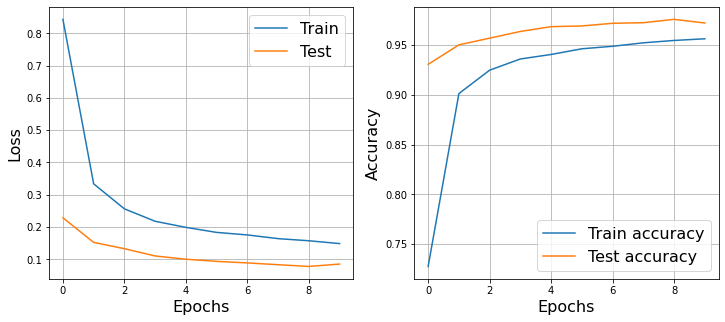

([0.8433567930513354,
  0.33386715588920407,
  0.2563582191716379,
  0.21786245887975958,
  0.19901159027619147,
  0.18338476910170462,
  0.1755309799062545,
  0.16405857556156003,
  0.15750649163146008,
  0.14874406992150013],
 [0.22874765286717233,
  0.1524769417187081,
  0.13287938522953022,
  0.11040493706830695,
  0.1002943427007221,
  0.09361182635390683,
  0.0888787187588743,
  0.08335162363239104,
  0.07794037708847583,
  0.08527811909023719],
 [0.72772855,
  0.9013082,
  0.9248401,
  0.9360841,
  0.94060946,
  0.9463175,
  0.9488384,
  0.9523088,
  0.9546797,
  0.9563621],
 [0.9306764,
  0.9502571,
  0.9569818,
  0.9637065,
  0.96855223,
  0.9692445,
  0.9719145,
  0.9725079,
  0.97587025,
  0.97221124])

In [106]:
from train_utils import train

layers = [nn.Linear(196, 128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(128,128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.139/0.072	Accuracy: 0.957/0.977


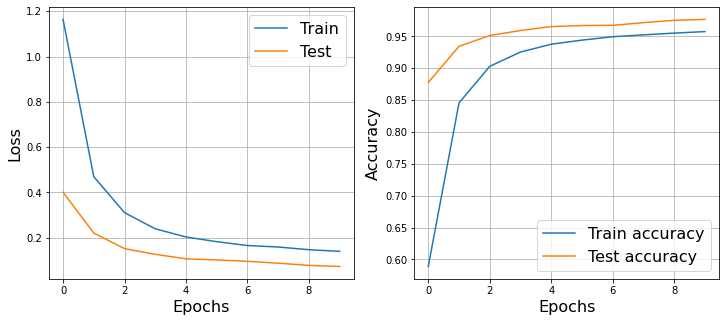

([1.1643860835764708,
  0.4690607231753721,
  0.31017801791493066,
  0.2386530759269749,
  0.20261420477936262,
  0.18183166923712313,
  0.16476114172893547,
  0.15826435856568788,
  0.1463301107128546,
  0.1391264986373913],
 [0.40027134686331206,
  0.2198548475398293,
  0.1510190597346312,
  0.1259745017778647,
  0.10606414277719546,
  0.1011225541086891,
  0.09498947585308098,
  0.08675094563042439,
  0.07702009938657284,
  0.07237485477913029],
 [0.58904135,
  0.84560454,
  0.9030017,
  0.925362,
  0.93766105,
  0.9440798,
  0.9494048,
  0.9523199,
  0.9550795,
  0.95746154],
 [0.8776701,
  0.9343355,
  0.9513449,
  0.9591574,
  0.96528876,
  0.9669699,
  0.9672666,
  0.971519,
  0.975178,
  0.9766614])

In [108]:
from train_utils import train

# По умолчанию p=0.5

layers = [DropConnect(196, 128),
          nn.ReLU(),
          DropConnect(128,128),
          nn.ReLU(),
          DropConnect(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Dropout и DropConnect уменьшают переобучение, test превосходит train

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [123]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(dim=1).view(-1, 1)
        std = x.std(dim=1).view(-1, 1)
        output = (x - mean)/((std+self.eps)**2)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
    
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.021/0.056	Accuracy: 0.993/0.983


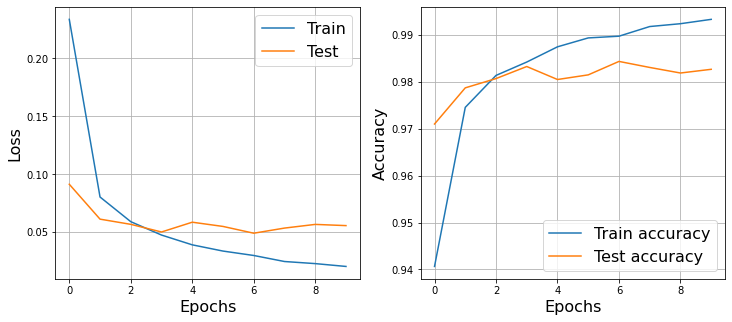

([0.23359514507196988,
  0.08042652707205399,
  0.05915359750405939,
  0.04762162477659709,
  0.03918603911642422,
  0.0338146053006384,
  0.030007041817002776,
  0.02480913248749128,
  0.023000874226343934,
  0.02055574102557576],
 [0.09141734645619423,
  0.06133956114372498,
  0.05685106319481436,
  0.050263699521369574,
  0.058702751475421686,
  0.05505468209474525,
  0.04920959563136006,
  0.05363080044913612,
  0.056807586876086044,
  0.0557654473066324],
 [0.9406428,
  0.9745747,
  0.98138773,
  0.9842417,
  0.98749,
  0.989389,
  0.98975545,
  0.9918155,
  0.99242073,
  0.993348],
 [0.9710245,
  0.9787381,
  0.980716,
  0.98328716,
  0.9805182,
  0.9815071,
  0.984375,
  0.9830894,
  0.9819027,
  0.98269385])

In [113]:
from train_utils import train

layers = [nn.Linear(196, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128,128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.034/0.060	Accuracy: 0.988/0.982


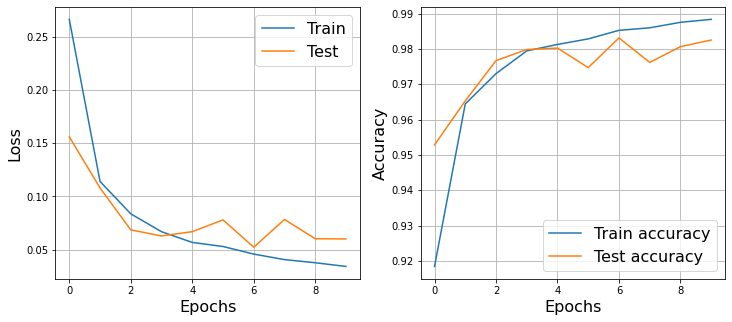

([0.2662511820287338,
  0.11394111114317801,
  0.08352482752767262,
  0.06672908715319945,
  0.056673145313848504,
  0.052838058667634726,
  0.045701320361056084,
  0.0405284042111727,
  0.03757622032843308,
  0.034098084912256105],
 [0.1558978970669493,
  0.1078434732471463,
  0.06847391515687297,
  0.06274499848213848,
  0.06676884967177263,
  0.0778238493595508,
  0.052163975879172736,
  0.07824863106766834,
  0.060131034474890634,
  0.059932155711458455],
 [0.91843796,
  0.96441346,
  0.9729922,
  0.9794221,
  0.9812433,
  0.9828203,
  0.9852357,
  0.98595196,
  0.9875067,
  0.9883451],
 [0.95282835,
  0.96528876,
  0.9766614,
  0.979826,
  0.9802215,
  0.9746835,
  0.9830894,
  0.9761669,
  0.9806171,
  0.982496])

In [124]:
from train_utils import train

layers = [nn.Linear(196, 128),
          LayerNormalization(),
          nn.ReLU(),
          nn.Linear(128,128),
          LayerNormalization(),
          nn.ReLU(),
          nn.Linear(128,10)]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

- Для данной архитектуры при батч нормализации сеть сходится быстрее
- Результаты в целом очень близки и превосходят предыдущие

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: